<div class="alert alert-block alert-info">

[1. Objectives](#1st-bullet)<br>  
[2. Import Data/Libraries](#2nd-bullet)<br>  
[3. Clustering Methods](#3rd-bullet)<br> 
- [3.1 K-Means](#6th-bullet)<br>
    - [3.1 Defining K](#6th-bullet)<br>
    - [3.1 Profiling](#7th-bullet)<br>
    - [3.1 Categorical Profiling](#8th-bullet)<br>
- [3.2 K means + Hierarchial clustering](#9th-bullet)<br>
    - [3.1 K-Means](#10th-bullet)<br>
    - [3.1 Hierarchial clustering](#11th-bullet)<br>
    - [3.1 Merging](#12th-bullet)<br>
    - [3.1 Profiling](#13th-bullet)<br>
    - [3.1 Categorical Profiling](#14th-bullet)<br>
- [3.3 Outliers](#6th-bullet)<br> 


</div>

<div class="alert alert-block alert-success">

<a class="anchor" id="1st-bullet">    </a>
## 1. Objectives 
</div>

<div class="alert alert-block alert-success">

<a class="anchor" id="2nd-bullet">    </a>
## 2. Import Data/Libraries
</div>

In [248]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.base import clone
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth

import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView
import warnings
warnings.filterwarnings("ignore")

We import our pre-proccessed data into our

In [249]:
data = pd.read_csv('data_general.csv')

In [250]:
data = data.set_index("ID")

In [251]:
data.columns

Index(['Age', 'UseByTime', 'AthleticsActivities', 'WaterActivities',
       'FitnessActivities', 'TeamActivities', 'RacketActivities',
       'CombatActivities', 'SpecialActivities', 'OtherActivities', 'Dropout',
       'Contract_Duration', 'PercentageOfVisits', 'PercentageOfClasses',
       'Freq_Visits_Day', 'Visits_ActivePeriod', 'Gender_Female'],
      dtype='object')

In [252]:
metric_features = ['Age','Contract_Duration', 'PercentageOfVisits', 'PercentageOfClasses',
       'Freq_Visits_Day', 'Visits_ActivePeriod']

non_metric_features = data.columns.drop(metric_features).to_list()
activities = ['AthleticsActivities', 'WaterActivities','FitnessActivities','TeamActivities','RacketActivities','CombatActivities','SpecialActivities','OtherActivities']


### Detection of outliers through DBSCAN

To detected the remaining outliers, and being that our data is highly skewed, a DBSCAN was applied.

 The parameteres defined are the following ( **ε** and **min_samples**): 
 
 -  **min_samples**  is, on a first approach, considered **2 x dim** where dim is the dimension of the metric features;
 - **ε** can be found by ploting a **k-distance graph** (distance to the kth (k = min_samples - 1) nearest neighbor ordered from the largest to the smallest value). The **elbow** of this graph is considered a good value for ε.

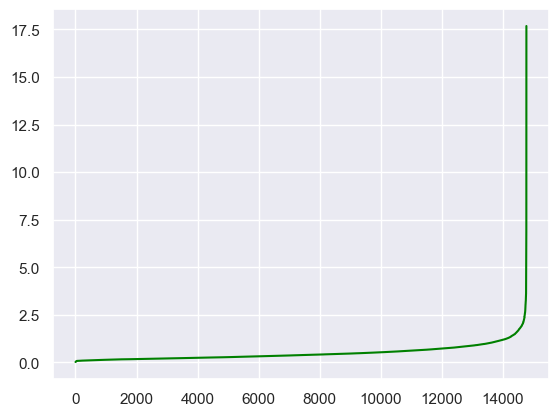

In [253]:
# epsilon of 1.5
neigh = NearestNeighbors(n_neighbors = (2 * len(metric_features)) - 1)
neigh.fit(data[metric_features])
distances, _ = neigh.kneighbors(data[metric_features])
distances = np.sort(distances[:, -1])
#plt.yticks(np.arange(1,22,0.5))
plt.plot(distances, color = 'green')
plt.show()

An **ε** of 1.5 is selected as the optimal value.

In [254]:
dbscan = DBSCAN(eps=1.5, min_samples = 2 * len(metric_features), n_jobs = -1)
dbscan_labels = dbscan.fit_predict(data[metric_features])

Counter(dbscan_labels)

Counter({0: 14597, -1: 176})

In [255]:
data.shape

(14773, 17)

In [256]:
#data = pd.concat([data, pd.Series(dbscan_labels, name = 'dbscan_labels', index = data.index)], axis =1)
data_dbscan_out = data[dbscan_labels == -1]
data = data[dbscan_labels != -1]

In [257]:
general_perspective = metric_features
compare = ['UseByTime','Dropout', 'Gender_Female']
df_activities = data[activities].copy()
df_general = data[general_perspective].copy()
df_compare = data[compare].copy()

<div class="alert alert-block alert-success">

<a class="anchor" id="3rd-bullet">    </a>
</div>

<div class="alert alert-block alert-success">

<a class="anchor" id="3rd-bullet">    </a>
## 3. Clustering Methods
</div>

## K-Means

In [258]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
       
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [259]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust

The optimum number of clusters was determined trough the usage of the `elbow method` and `silhouette analysis`. 
Both methods provided slighly different insights.
The `elbow` appears to be when k = 4, but the highest `average silhouette` is when k = 5.

When comparing the two values for k, there wasn't a significant difference. It was therefore decided to use k = 4 because, besides being the value for the `elbow`, this point has the second greater `average silhouette`. It also seemed to present better results when using this number of clusters while using multiple algorithms.

In [260]:
range_clusters = range(1, 11)
inertia = []
for n_clus in range_clusters:  
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_general[metric_features])
    inertia.append(kmclust.inertia_)  

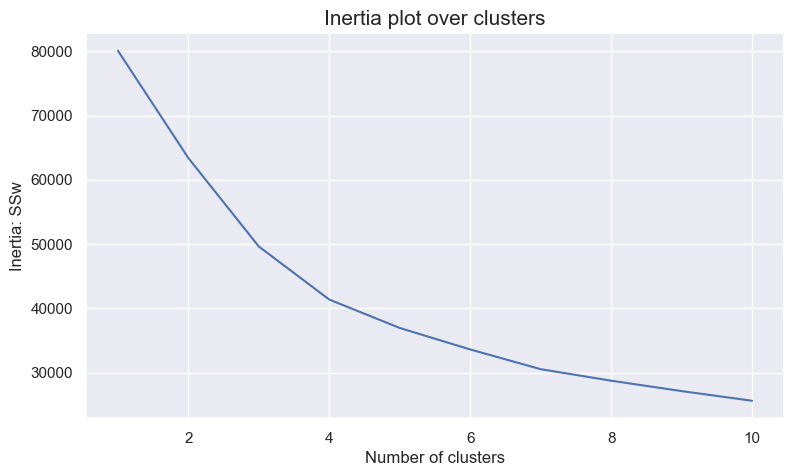

In [261]:
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.3016861343935349
For n_clusters = 3, the average silhouette_score is : 0.3164949109412034
For n_clusters = 4, the average silhouette_score is : 0.3224280860532069
For n_clusters = 5, the average silhouette_score is : 0.3247809487059975
For n_clusters = 6, the average silhouette_score is : 0.26723679681037604
For n_clusters = 7, the average silhouette_score is : 0.2779285038521495
For n_clusters = 8, the average silhouette_score is : 0.2836338609294582
For n_clusters = 9, the average silhouette_score is : 0.2894758518112626
For n_clusters = 10, the average silhouette_score is : 0.26469069923016697


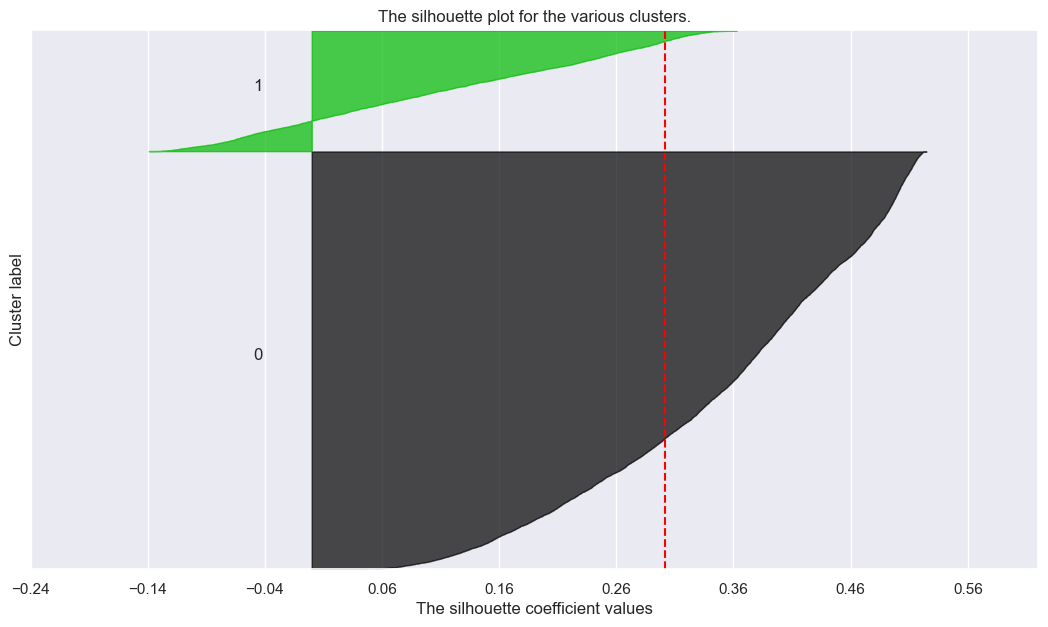

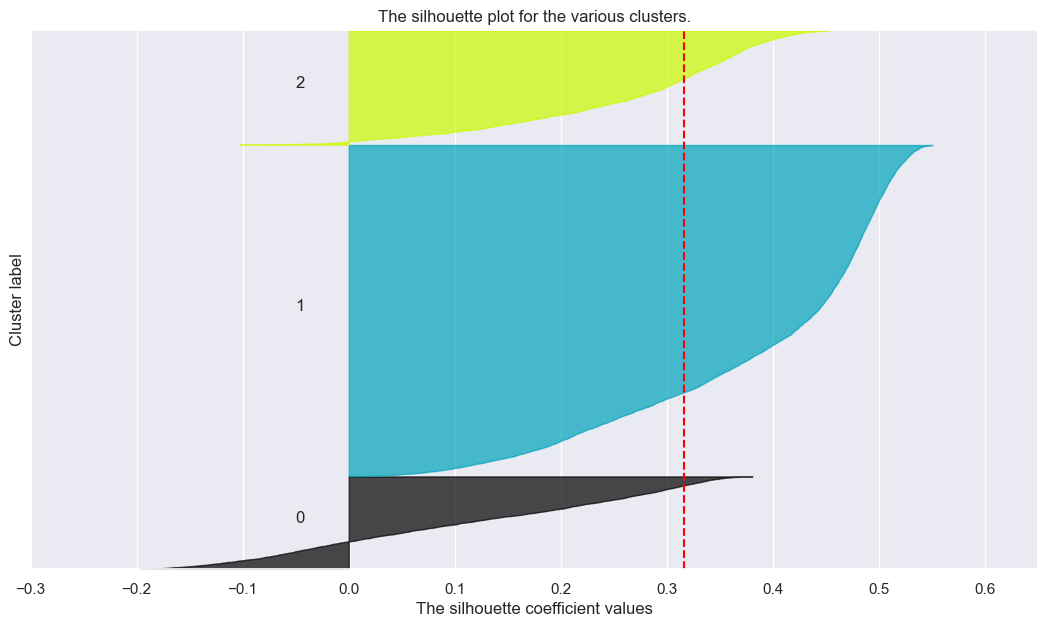

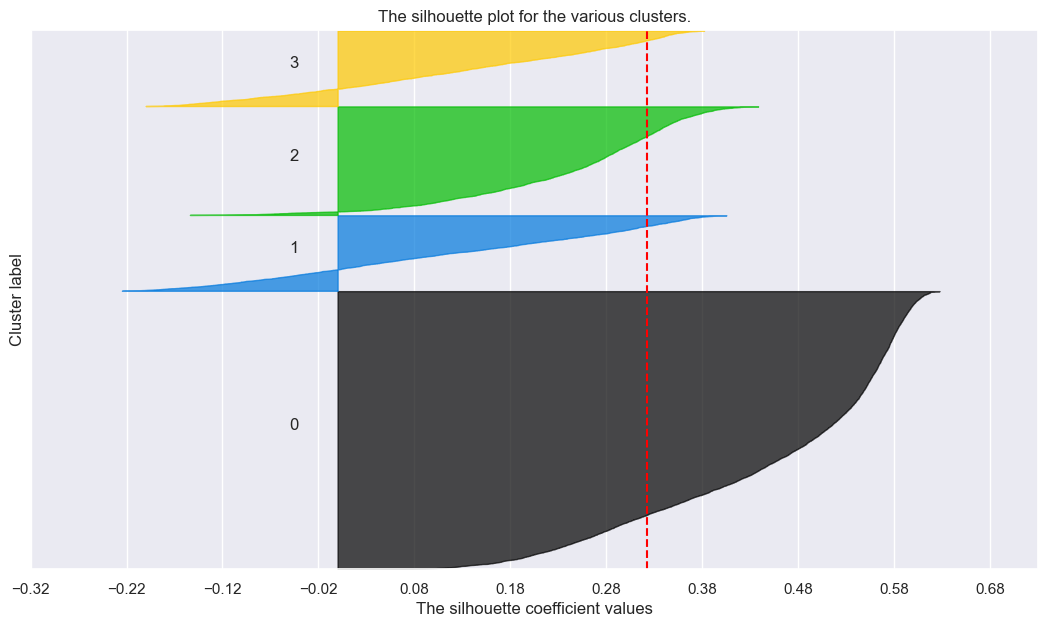

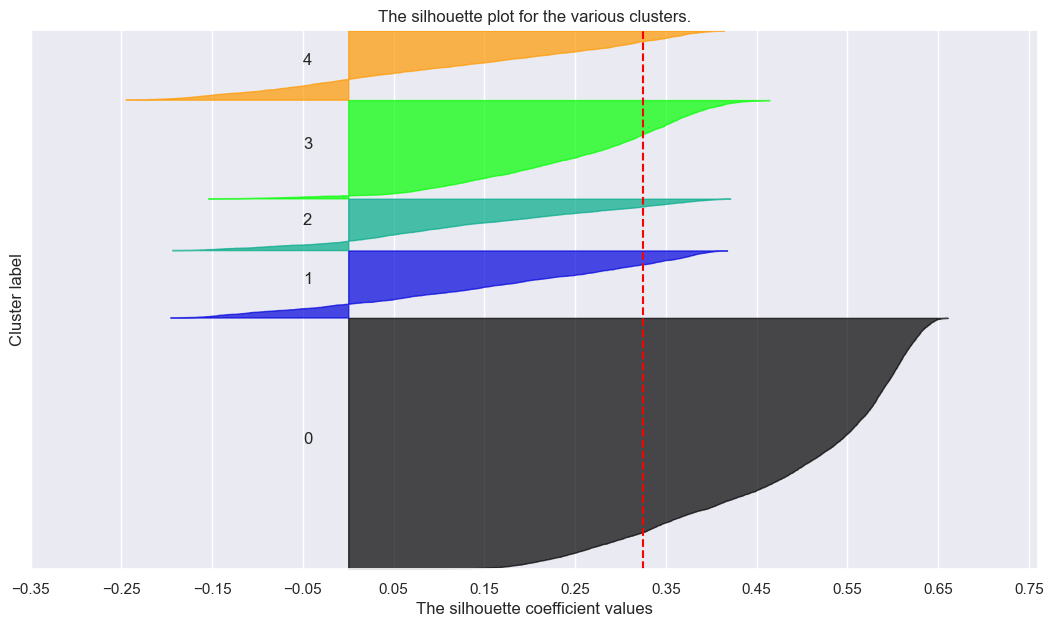

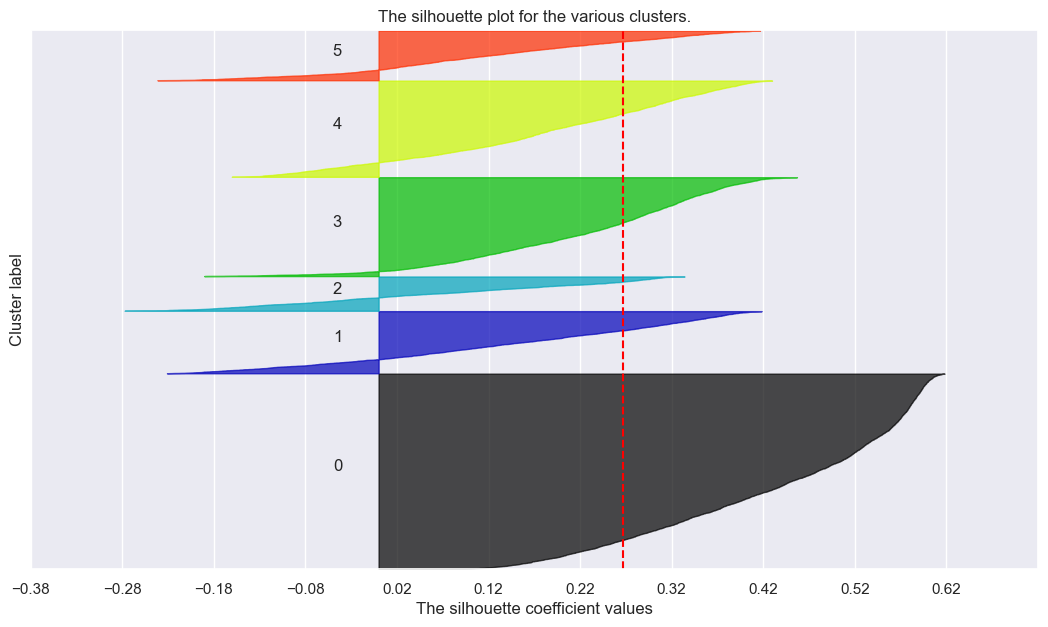

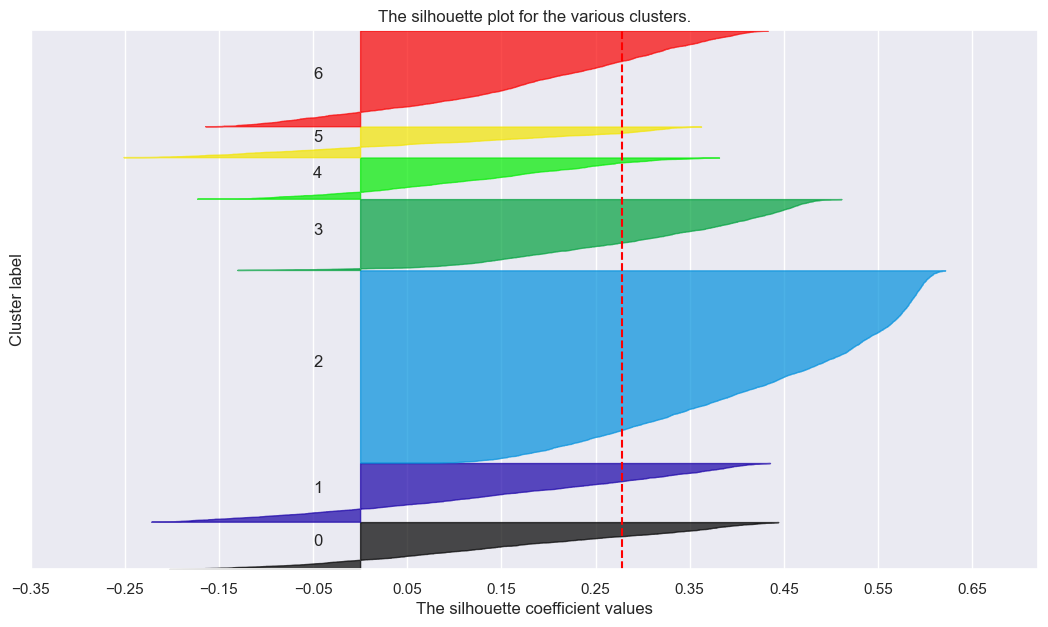

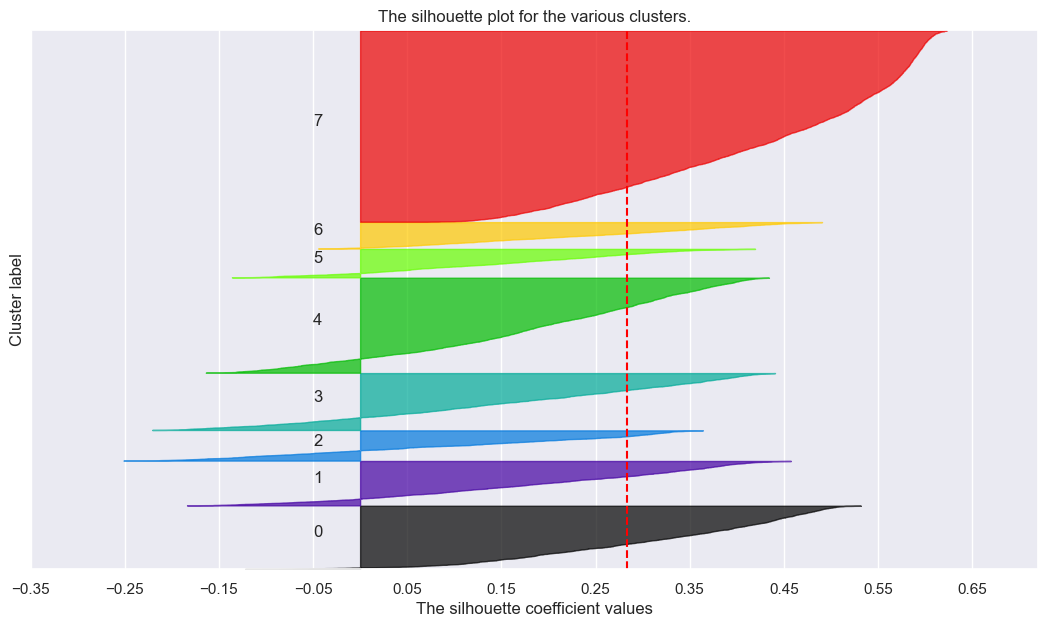

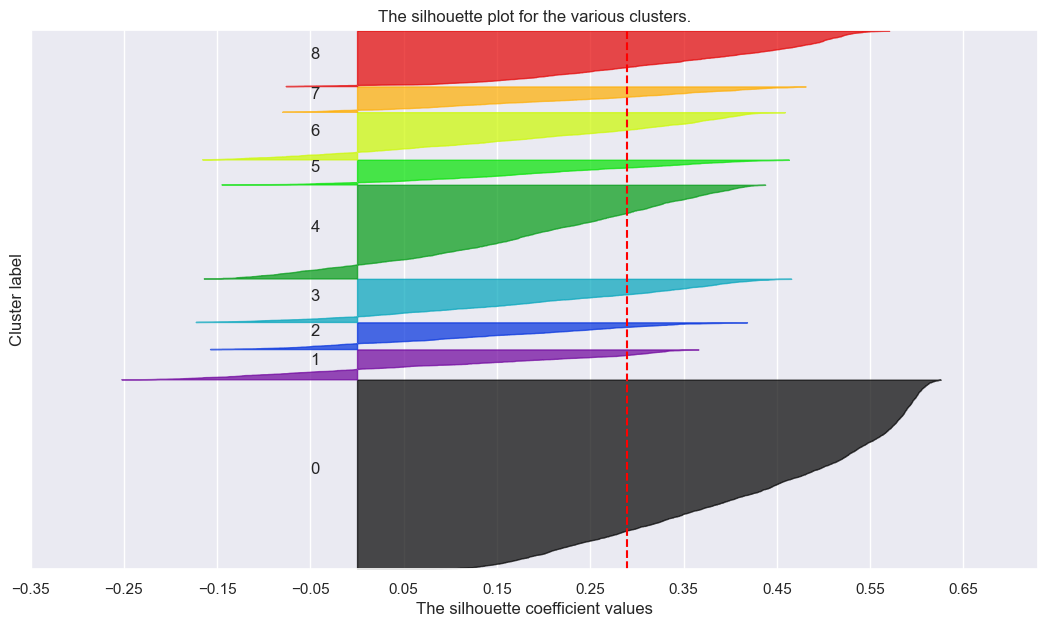

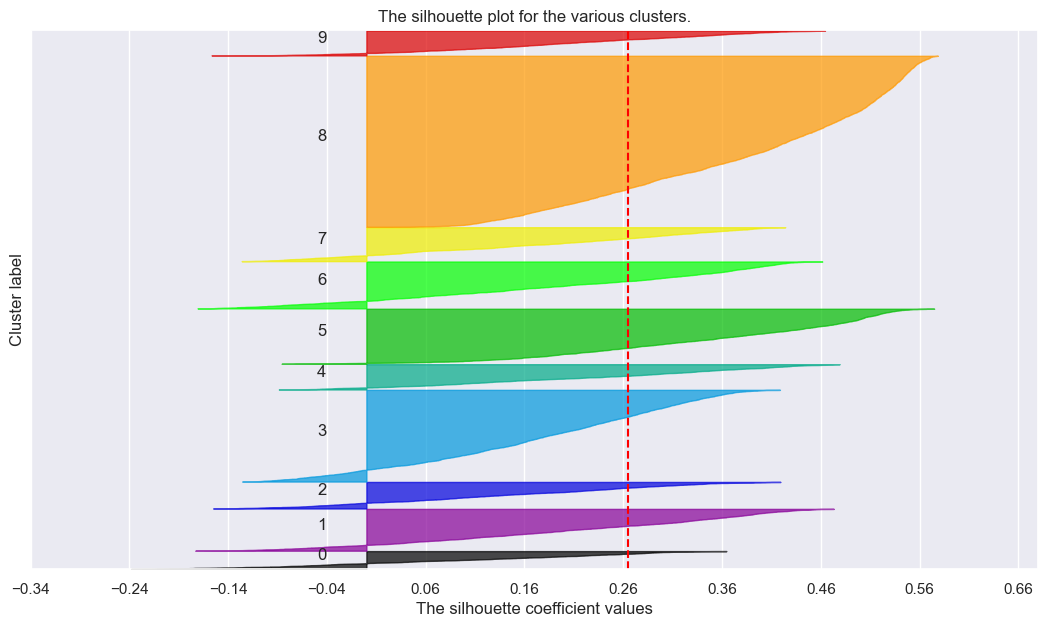

In [262]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df_general[metric_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_general[metric_features], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_general[metric_features], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_general[metric_features]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

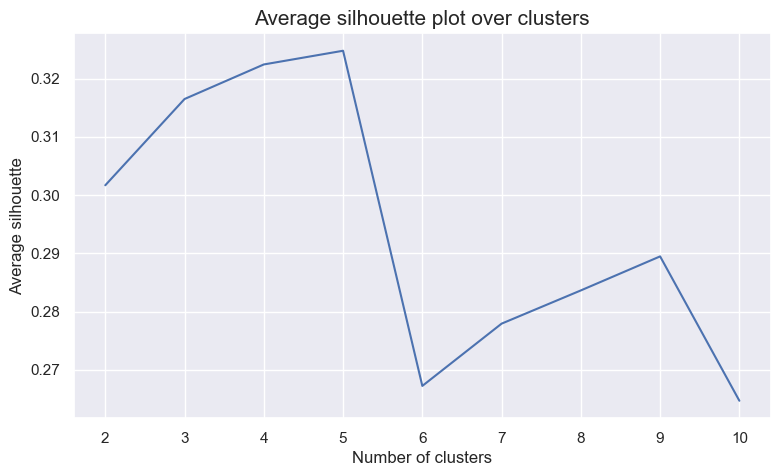

In [263]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(range_clusters[1:], 
         avg_silhouette)     

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

Using k = 4

In [264]:
number_clusters = 4
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df_general[metric_features])
km_labels

array([3, 0, 0, ..., 1, 1, 1])

In [271]:
df_concat = pd.concat((data, pd.Series(km_labels, name='labels', index=data.index)), axis=1)

In [272]:
sst = get_ss(df_concat[metric_features])  # get total sum of squares
ssw_labels = df_concat[metric_features + ["labels"]].groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.4836174980931746

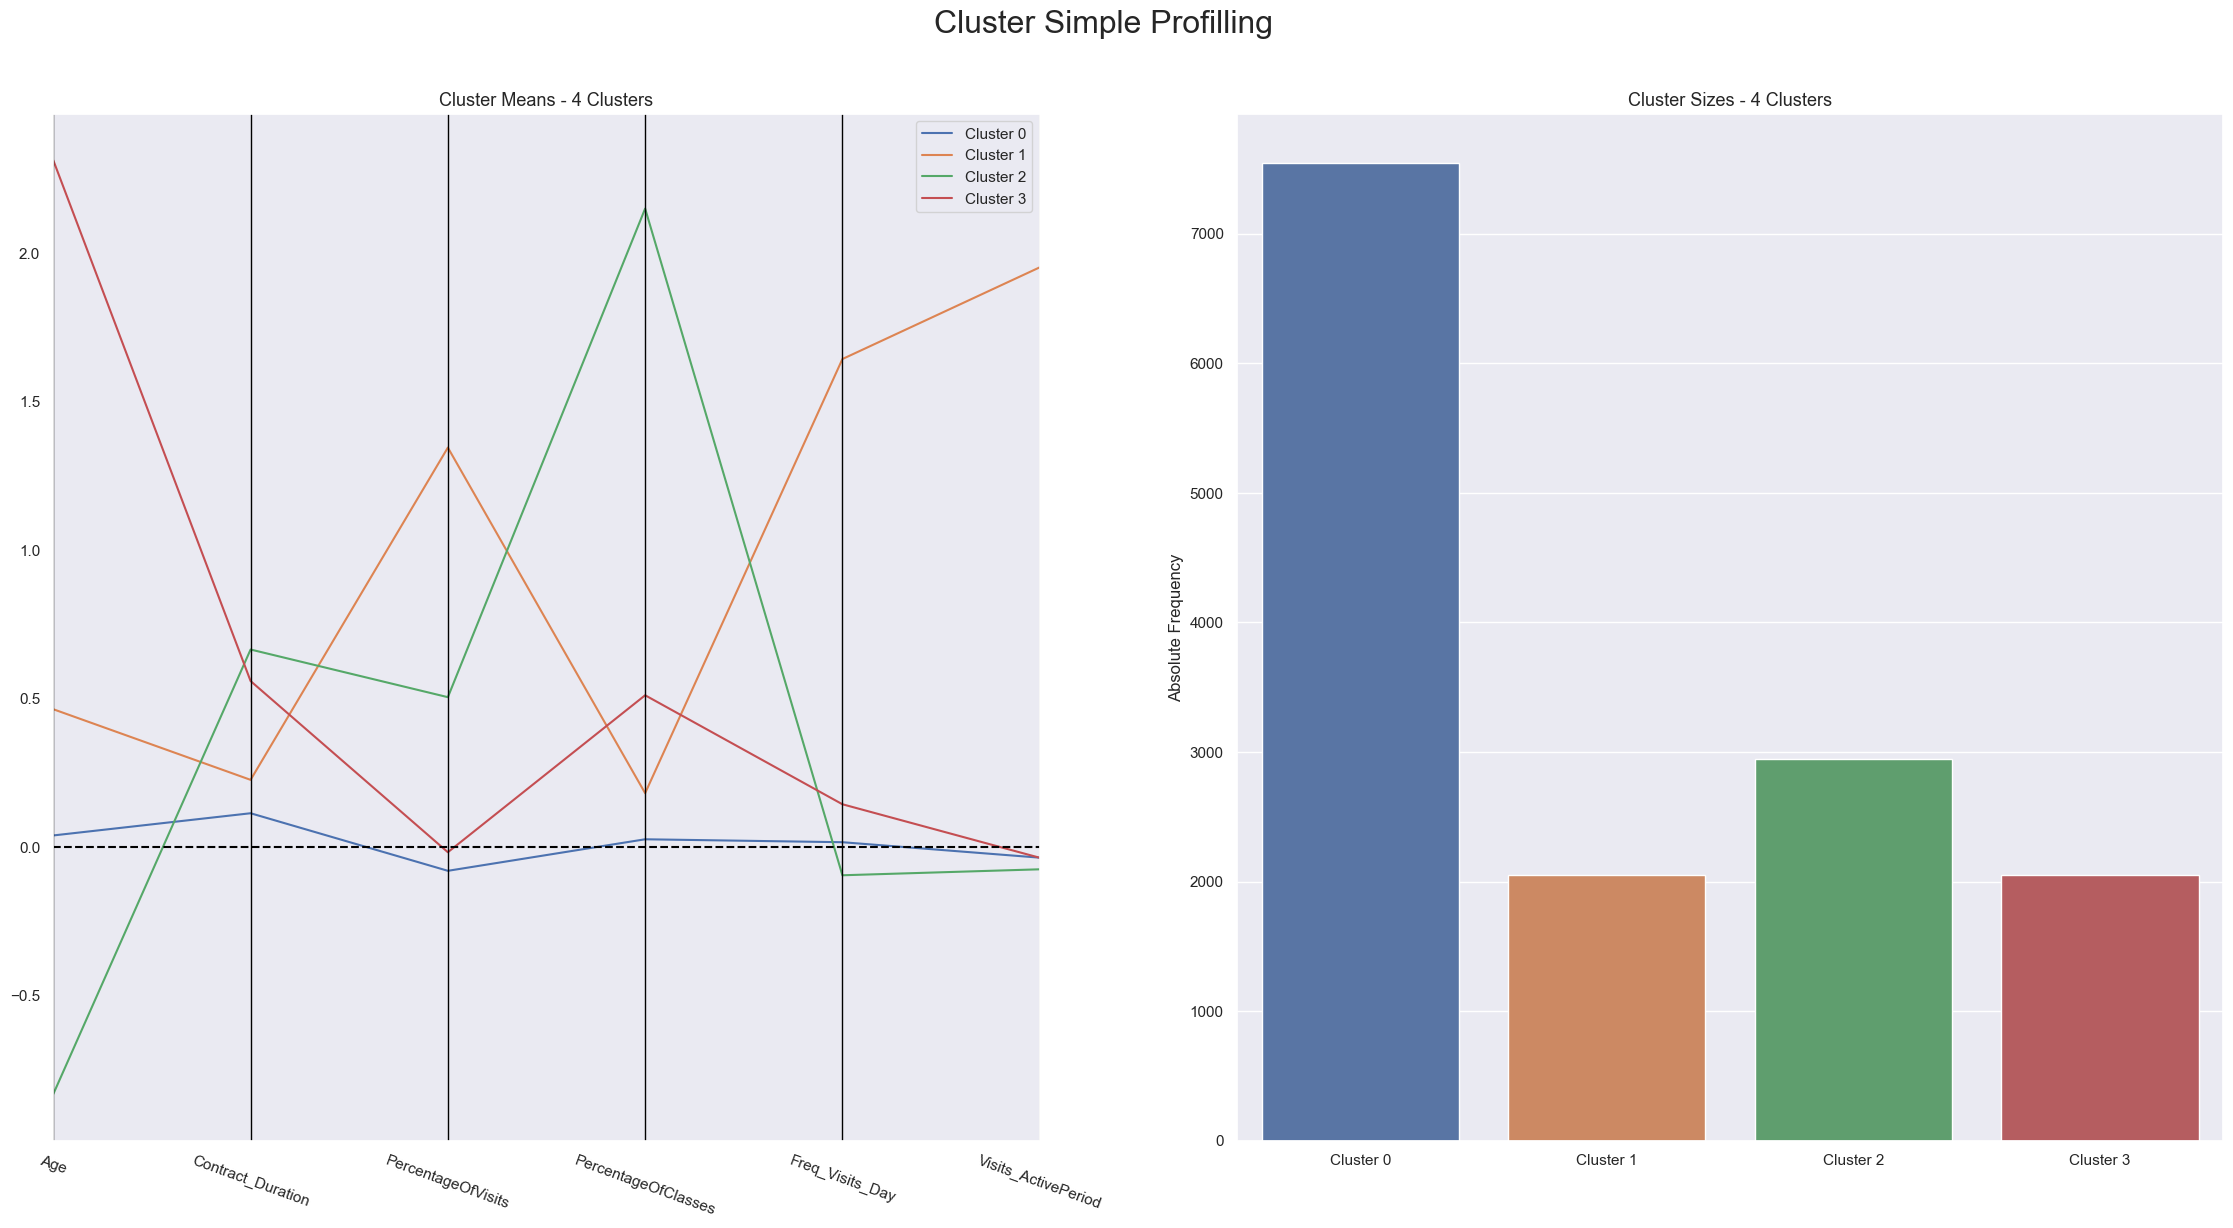

In [273]:
cluster_profiles(
    df = df_concat[metric_features + ["labels"]], 
    label_columns = ["labels"], 
    figsize = (28, 13), 
    compar_titles = [""]
)

As it can be observed there is a high inbalance between cluster 0 and the other 3 clusters. This will be taken later into consideration when choosing which is the most appropriate model to retrieve information about the customers.

### Profiling with categorical variables

The percentage of people who practiced an activity within each group was studied below. This approach was used due to the high inbalanced within the categorical features.

In [276]:
df_act= df_concat[["labels"] + activities].groupby(["labels"]).sum()
df_compare= df_concat[["labels"] + compare].groupby(["labels"]).sum()

In [277]:
df_act.apply(lambda col: col/(col.sum())).style.format(precision=2).background_gradient(axis=0)

,AthleticsActivities,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,CombatActivities,SpecialActivities,OtherActivities
labels,,,,,,,,
0,0.58,0.26,0.65,0.21,0.12,0.78,0.19,0.43
1,0.14,0.10,0.18,0.04,0.06,0.06,0.25,0.11
2,0.10,0.50,0.01,0.69,0.72,0.07,0.07,0.21
3,0.18,0.14,0.16,0.06,0.10,0.08,0.49,0.25


In [278]:
df_compare.apply(lambda col: col/(col.sum())).style.format(precision=2).background_gradient(axis=0)

,UseByTime,Dropout,Gender_Female
labels,,,
0,0.55,0.57,0.53
1,0.20,0.12,0.13
2,0.04,0.17,0.19
3,0.21,0.14,0.15


## K means + Hierarchial clustering

In [ ]:
# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    metric='euclidean'
)

In [ ]:
# Obtaining the R² scores for each cluster solution on the general perspective
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_general, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_general, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.208653,0.104587,0.117413,0.000180,0.182513
3,0.380557,0.233648,0.119931,0.000494,0.310254
4,0.483618,0.256240,0.120674,0.000733,0.417487
5,0.538811,0.344855,0.125483,0.001049,0.471779
6,0.580552,0.355246,0.166874,0.001282,0.507947
7,0.618876,0.375946,0.181015,0.001678,0.543510
8,0.641259,0.385068,0.208436,0.001917,0.572332
9,0.659857,0.431485,0.213340,0.002309,0.595707


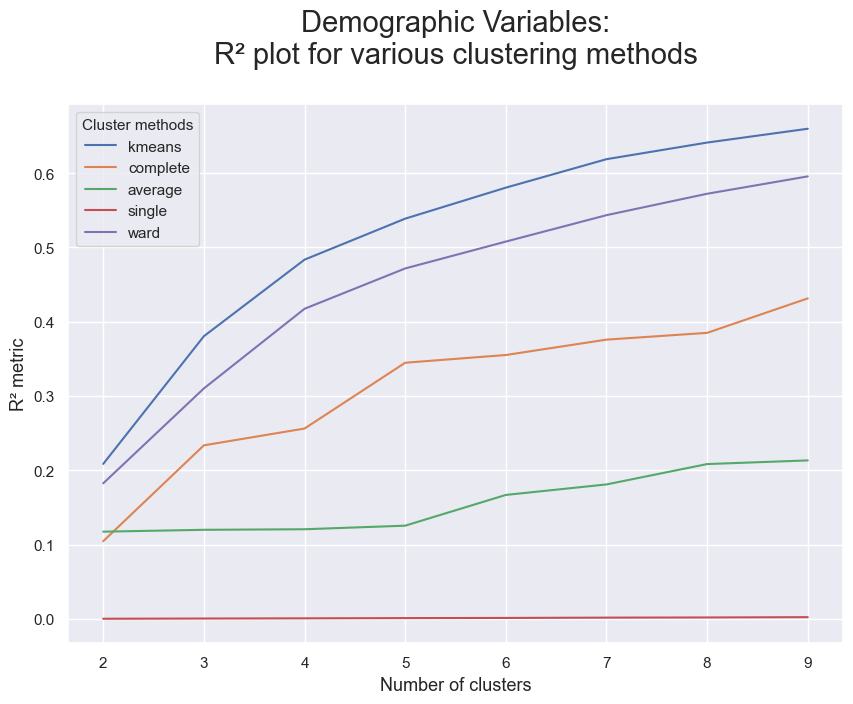

In [ ]:
# Visualizing the R² scores for each cluster solution on general perspective
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("General Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

K-Means using k = 4

In [ ]:
kmeans_general = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=20,
    random_state=42
)
general_labels = kmeans_general.fit_predict(df_general)
data['general_labels'] = general_labels


In [ ]:
df_centroids = data.groupby(['general_labels'])\
    [metric_features].mean()
df_centroids

,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod
general_labels,,,,,,
0,0.038158,0.114561,-0.078747,0.026045,0.016991,-0.033725
1,-0.831610,0.665351,0.504832,2.150256,-0.094946,-0.074856
2,2.310521,0.557382,-0.019581,0.510083,0.143026,-0.037131
3,0.467450,0.225497,1.348776,0.183229,1.648693,1.954348


hierarchical clustering

In [ ]:
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

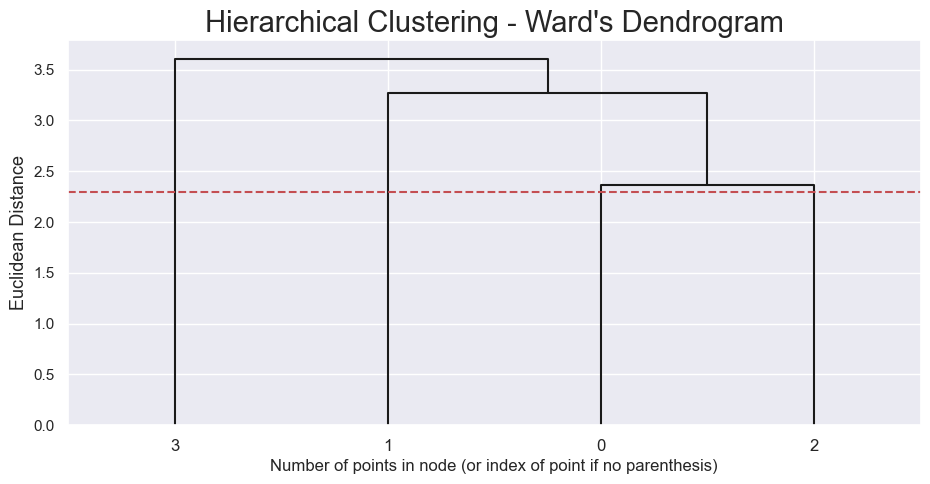

In [ ]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 2.3
dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

Using 4 clusters for hierarchical clustering

In [ ]:
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=4
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  

,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod,hclust_labels
general_labels,,,,,,,
0,0.038158,0.114561,-0.078747,0.026045,0.016991,-0.033725,3
1,-0.831610,0.665351,0.504832,2.150256,-0.094946,-0.074856,2
2,2.310521,0.557382,-0.019581,0.510083,0.143026,-0.037131,1
3,0.467450,0.225497,1.348776,0.183229,1.648693,1.954348,0


In [ ]:
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = data.copy()

df_['general_labels'] = df_['general_labels'].map(cluster_mapper)

df_.groupby('general_labels').mean()[metric_features]


,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod
general_labels,,,,,,
0,0.467450,0.225497,1.348776,0.183229,1.648693,1.954348
1,2.310521,0.557382,-0.019581,0.510083,0.143026,-0.037131
2,-0.831610,0.665351,0.504832,2.150256,-0.094946,-0.074856
3,0.038158,0.114561,-0.078747,0.026045,0.016991,-0.033725


In [ ]:
df_

,Age,UseByTime,AthleticsActivities,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,CombatActivities,SpecialActivities,OtherActivities,Dropout,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod,Gender_Female,general_labels
ID,,,,,,,,,,,,,,,,,,
10000,3.083333,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,-0.490868,1.15,1.866571,0.763419,-0.201465,1,1
10001,0.500000,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.285388,-0.20,0.104392,-0.204771,-0.501832,1,3
10002,0.000000,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,-0.554795,0.50,0.000000,1.208748,0.619048,0,3
10003,-1.166667,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,-0.257991,0.35,0.239981,0.463221,-0.300366,0,3
10004,1.000000,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1.152968,-0.50,0.000000,-0.255467,-0.600733,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24937,-0.750000,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.997717,0.65,2.056875,0.190855,1.000000,0,2
24938,1.333333,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,-0.027397,-0.25,0.000000,1.391650,0.007326,0,1
24939,-0.250000,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,-0.554795,0.85,0.000000,1.208748,1.025641,0,0


In [ ]:
df = df_.copy()

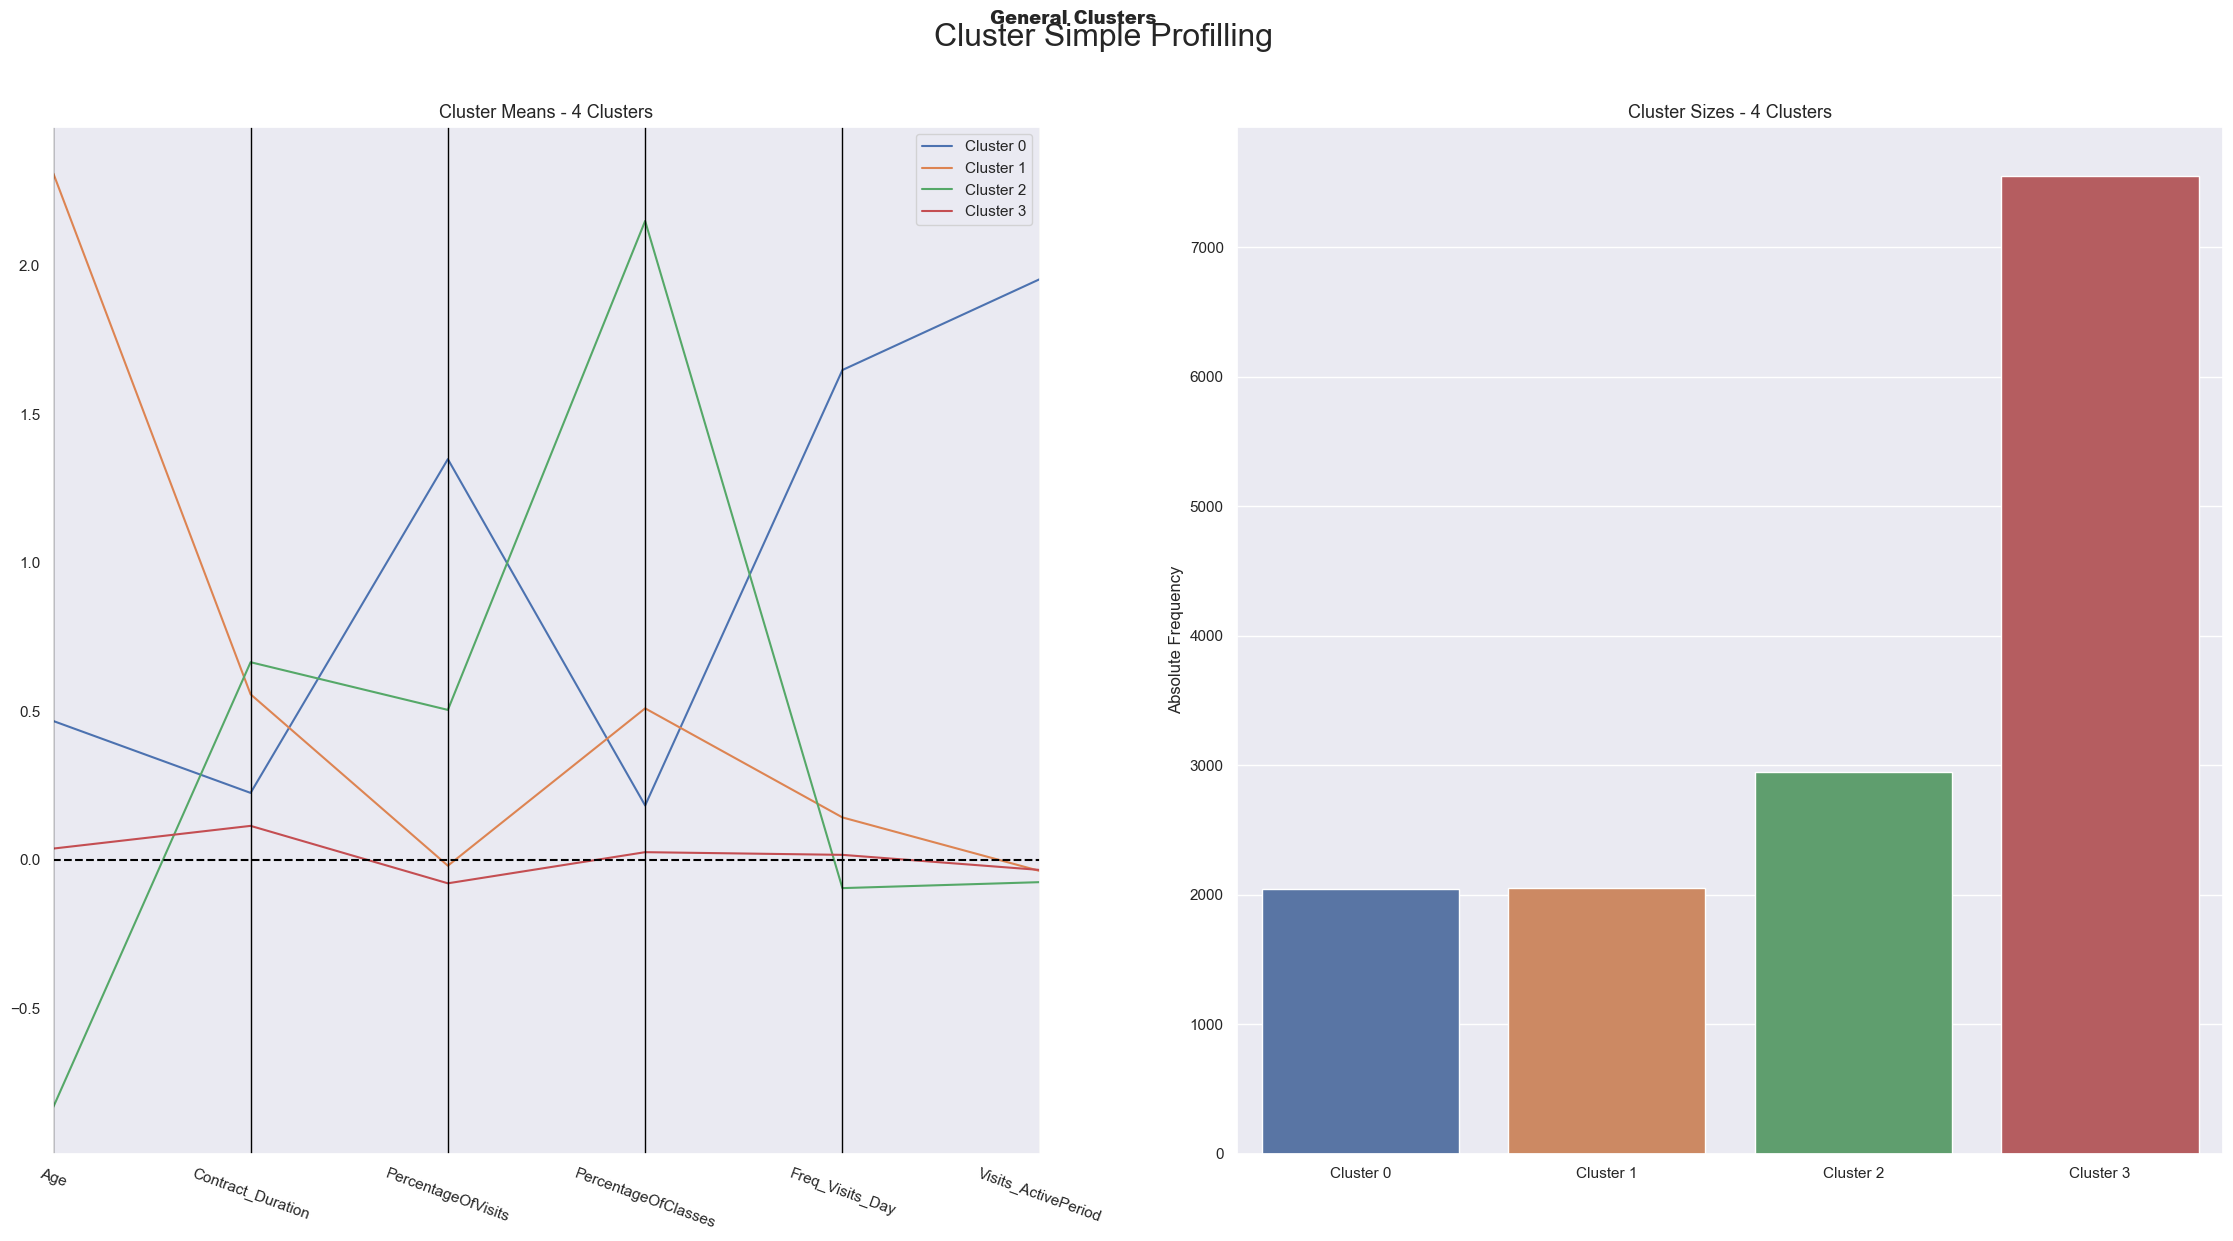

In [232]:
# Profilling each cluster
cluster_profiles(
    df = df[metric_features + ['general_labels']],
    label_columns = ['general_labels'], 
    figsize = (28, 13), 
    compar_titles = ["General Clusters"]
)

We study the percentage of people who do an activity belong to this group. Since our activities are very unbalanced, this way we can see what percentage of all participants belong to a certain group:

In [234]:
df_act= df[["general_labels"] + activities].groupby(["general_labels"]).sum()
df_compare= df[["general_labels"] + compare].groupby(["general_labels"]).sum()

In [235]:
df_act.apply(lambda col: col/(col.sum())).style.format(precision=2).background_gradient(axis=0)

,AthleticsActivities,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,CombatActivities,SpecialActivities,OtherActivities
general_labels,,,,,,,,
0,0.14,0.10,0.18,0.04,0.06,0.06,0.25,0.11
1,0.18,0.14,0.16,0.06,0.10,0.08,0.49,0.25
2,0.10,0.50,0.01,0.69,0.72,0.07,0.07,0.21
3,0.58,0.26,0.65,0.21,0.12,0.78,0.19,0.43


In [236]:
df_compare.apply(lambda col: col/(col.sum())).style.format(precision=2).background_gradient(axis=0)

,UseByTime,Dropout,Gender_Female
general_labels,,,
0,0.20,0.12,0.13
1,0.21,0.14,0.15
2,0.04,0.17,0.19
3,0.55,0.57,0.53


In [242]:
df_compare = df[['general_labels','UseByTime', 'Dropout', 'Gender_Female']].groupby(['general_labels']).sum()

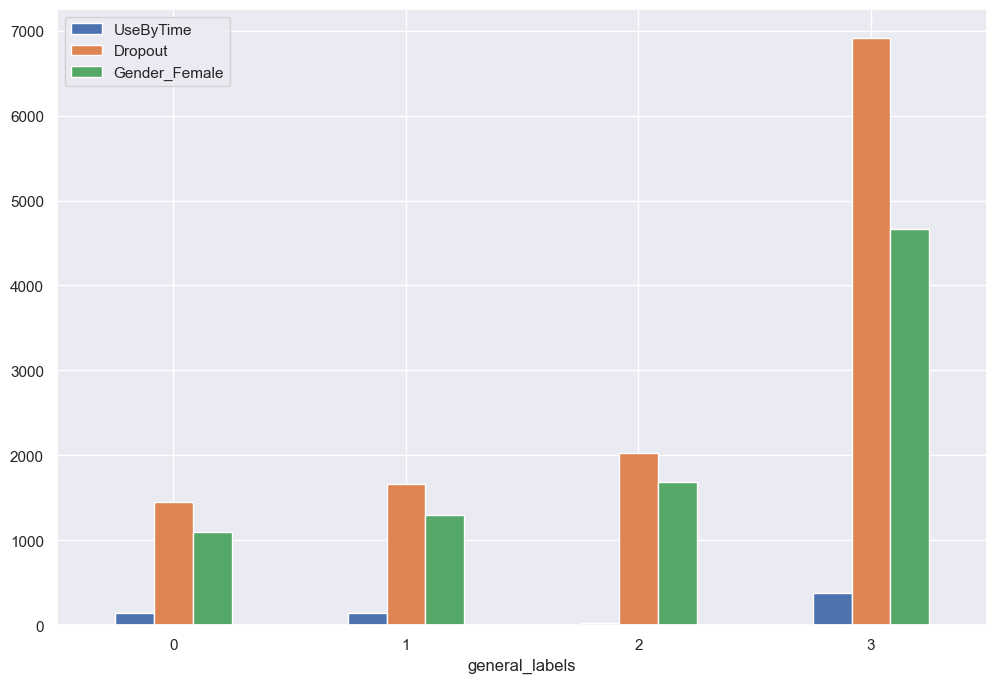

In [243]:
fig, ax = plt.subplots(figsize=(12,8))
df_compare.plot(kind='bar', stacked=False, ax=ax)
plt.xticks(rotation=0)
plt.show()

In [244]:
df_activities = data[['general_labels','AthleticsActivities', 'WaterActivities', 'FitnessActivities',
       'TeamActivities', 'RacketActivities', 'CombatActivities',
       'SpecialActivities', 'OtherActivities']].groupby(['general_labels']).sum()

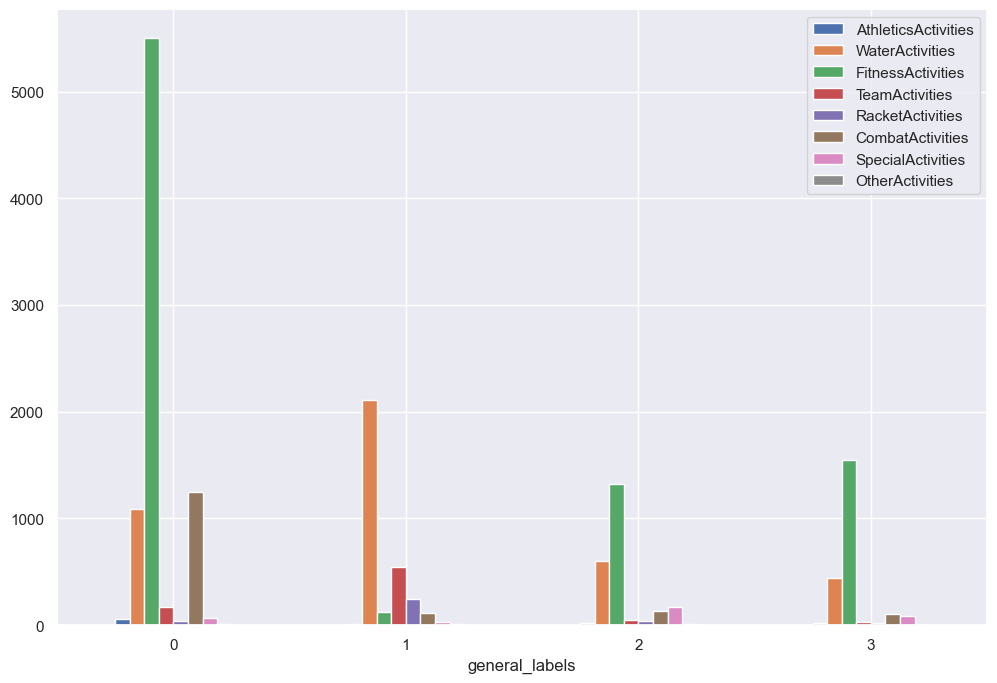

In [245]:
fig, ax = plt.subplots(figsize=(12,8))
df_activities.plot(kind='bar', stacked=False, ax=ax)
plt.xticks(rotation=0)
plt.show()

### SOM + K-means clustering

In [53]:
#set the random seed for reproducibility
np.random.seed(42)

#build a Self-Organizing Map
sm = sompy.SOMFactory().build(
    df_general.values, 
    mapsize=[50, 50],
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)

# Training the SOM
sm.train(n_job=-1, verbose='info', train_rough_len=50, train_finetune_len=50)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 50

 epoch: 1 ---> elapsed time:  6.237000, quantization error: 1.578947

 epoch: 2 ---> elapsed time:  5.913000, quantization error: 2.179240

 epoch: 3 ---> elapsed time:  6.333000, quantization error: 2.154505

 epoch: 4 ---> elapsed time:  6.123000, quantization error: 2.145272

 epoch: 5 ---> elapsed time:  6.263000, quantization error: 2.140666

 epoch: 6 ---> elapsed time:  6.479000, quantization error: 2.137605

 epoch: 7 ---> elapsed time:  6.247000, quantization error: 2.134150

 epoch: 8 ---> elapsed time:  6.175000, quantization error: 2.131565

 epoch: 9 ---> elapsed time:  7.522000, quantization error: 2.129228

 epoch: 10 ---> elapsed time:  7.124000, quantization error: 2.126370

 epoch: 11 ---> elapsed time:  5.422000, quantization error: 2.122371

 epoch: 12 ---> elapsed time:  6.524000, quantization error: 2.118163

 epoch: 13 ---> 

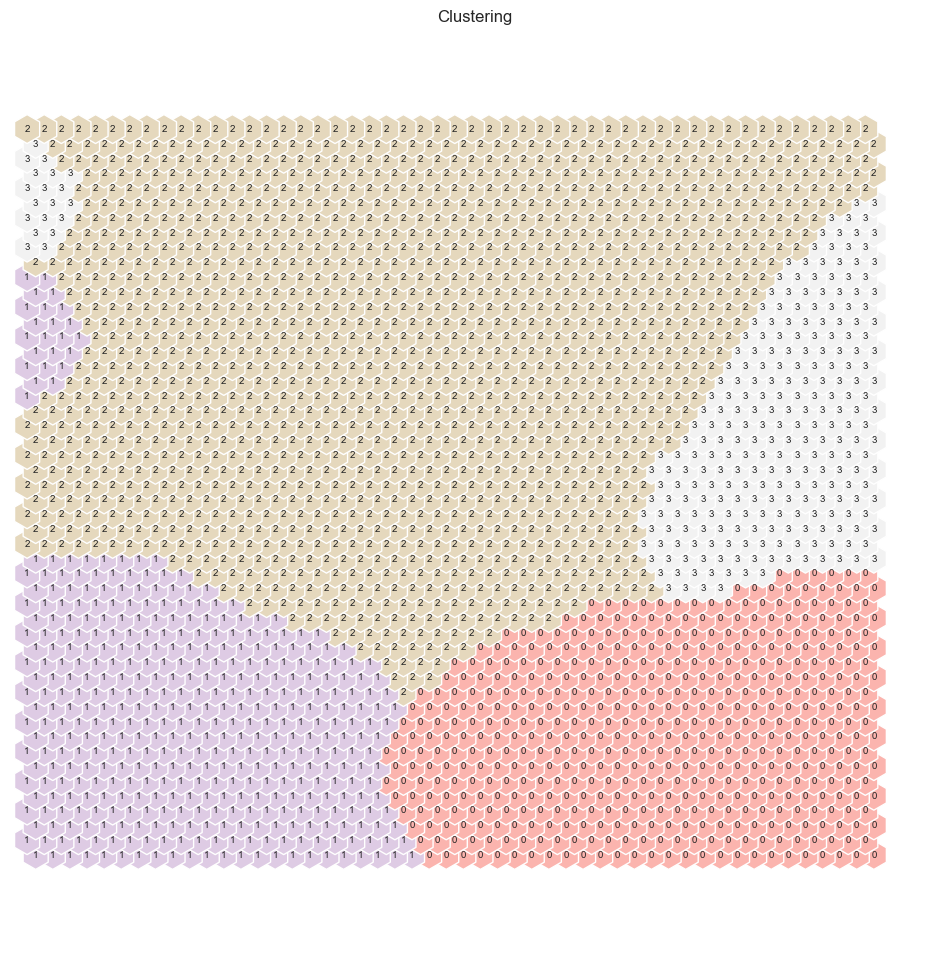

In [56]:
#perform K-Means clustering on top of the sm.get_node_vectors() output
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels 

#hitmap to show cluster distribution
hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

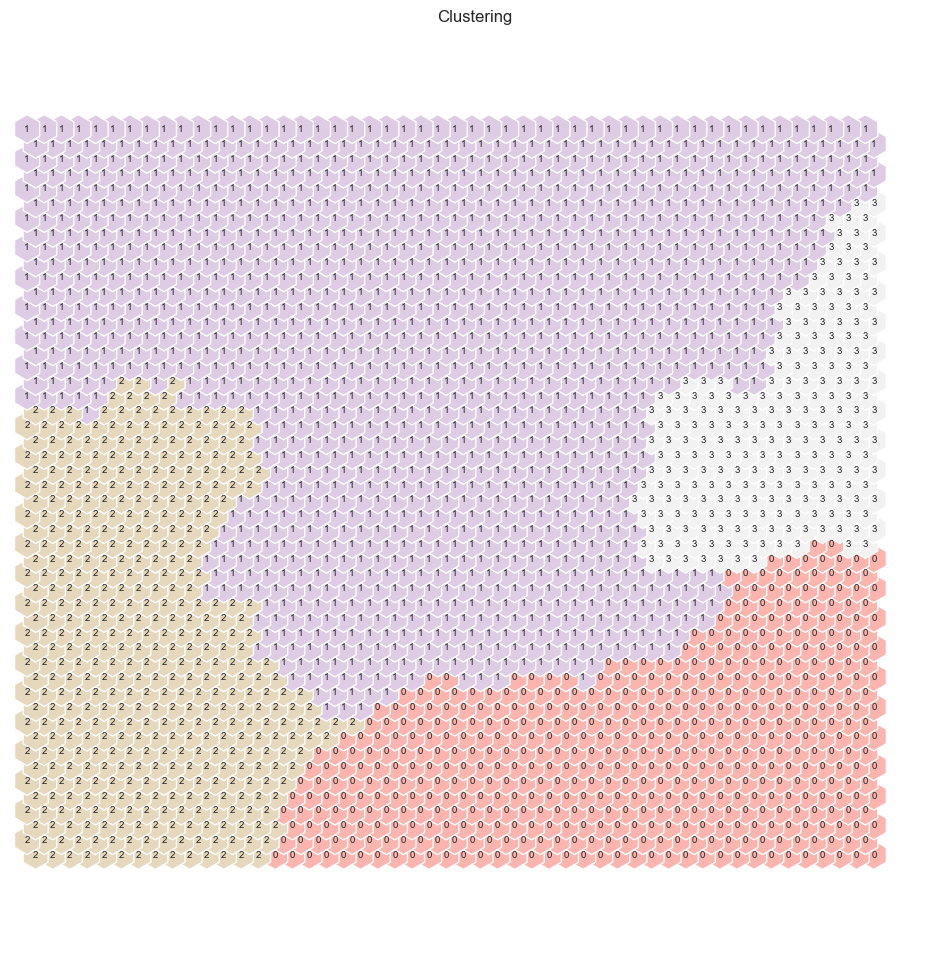

In [57]:
#perform hierarchical clustering on top of SOM
hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels = hierclust.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels 

#hitmap to show cluster distribution
hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [58]:
#extract the codebook matrix from the trained SOM model - this matrix contains the weight vectors of the nodes (neurons) in the SOM
nodes = sm.codebook.matrix

df_nodes = pd.DataFrame(nodes, columns=metric_features)

#this column will be filled with cluster labels for each node
df_nodes['label'] = nodeclus_labels
df_nodes

,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod,label
0,0.209958,-0.188511,-0.810935,-0.565970,-0.882669,-0.740485,1
1,0.105926,-0.154045,-0.823025,-0.567176,-0.888775,-0.749402,1
2,-0.024448,-0.143320,-0.833965,-0.563052,-0.921742,-0.759726,1
3,-0.170028,-0.151543,-0.830691,-0.571117,-0.954005,-0.754168,1
4,-0.320393,-0.190240,-0.836630,-0.574310,-0.975924,-0.760365,1
...,...,...,...,...,...,...,...
2495,2.120411,0.067134,1.692314,-0.519534,2.195859,3.672117,2
2496,1.667268,0.170266,2.002994,-0.515766,2.256645,4.209992,2
2497,1.088754,0.496753,2.368503,-0.520140,2.092657,4.834008,2
2498,0.743234,0.793725,2.659854,-0.523925,2.081337,5.394395,2


In [59]:
#find the Best Matching Units (BMUs) for each data point using the trained SOM
bmus_map = sm.find_bmu(df_general)[0]

#create a DataFrame from the BMUs
df_bmus = pd.DataFrame(
    np.concatenate((df_general, np.expand_dims(bmus_map,1)), axis=1),
    index=df_general.index, columns=np.append(df_general.columns,"BMU")
)
df_bmus

,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod,BMU
ID,,,,,,,
10000,3.083333,-0.490868,1.15,1.866571,0.763419,-0.201465,2126.0
10001,0.500000,0.285388,-0.20,0.104392,-0.204771,-0.501832,200.0
10002,0.000000,-0.554795,0.50,0.000000,1.208748,0.619048,1641.0
10003,-1.166667,-0.257991,0.35,0.239981,0.463221,-0.300366,1720.0
10004,1.000000,1.152968,-0.50,0.000000,-0.255467,-0.600733,350.0
...,...,...,...,...,...,...,...
24937,-0.750000,1.997717,0.65,2.056875,0.190855,1.000000,1554.0
24938,1.333333,-0.027397,-0.25,0.000000,1.391650,0.007326,948.0
24939,-0.250000,-0.554795,0.85,0.000000,1.208748,1.025641,1741.0


In [60]:
#set cluster labels for each observation
df_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)
df_final

,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod,BMU,label
ID,,,,,,,,
10000,3.083333,-0.490868,1.15,1.866571,0.763419,-0.201465,2126.0,0
10001,0.500000,0.285388,-0.20,0.104392,-0.204771,-0.501832,200.0,1
10002,0.000000,-0.554795,0.50,0.000000,1.208748,0.619048,1641.0,2
10003,-1.166667,-0.257991,0.35,0.239981,0.463221,-0.300366,1720.0,1
10004,1.000000,1.152968,-0.50,0.000000,-0.255467,-0.600733,350.0,3
...,...,...,...,...,...,...,...,...
24937,-0.750000,1.997717,0.65,2.056875,0.190855,1.000000,1554.0,0
24938,1.333333,-0.027397,-0.25,0.000000,1.391650,0.007326,948.0,1
24939,-0.250000,-0.554795,0.85,0.000000,1.208748,1.025641,1741.0,2


In [62]:
cluster_means = df_final.groupby('label').mean()[metric_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1)

label,0,1,2,3
Age,-0.52,0.59,0.35,0.39
Contract_Duration,0.59,-0.07,0.13,1.52
PercentageOfVisits,0.67,-0.10,0.89,-0.01
PercentageOfClasses,2.04,0.08,0.03,0.12
Freq_Visits_Day,-0.01,-0.03,1.55,-0.03
Visits_ActivePeriod,0.04,-0.06,1.56,0.09


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


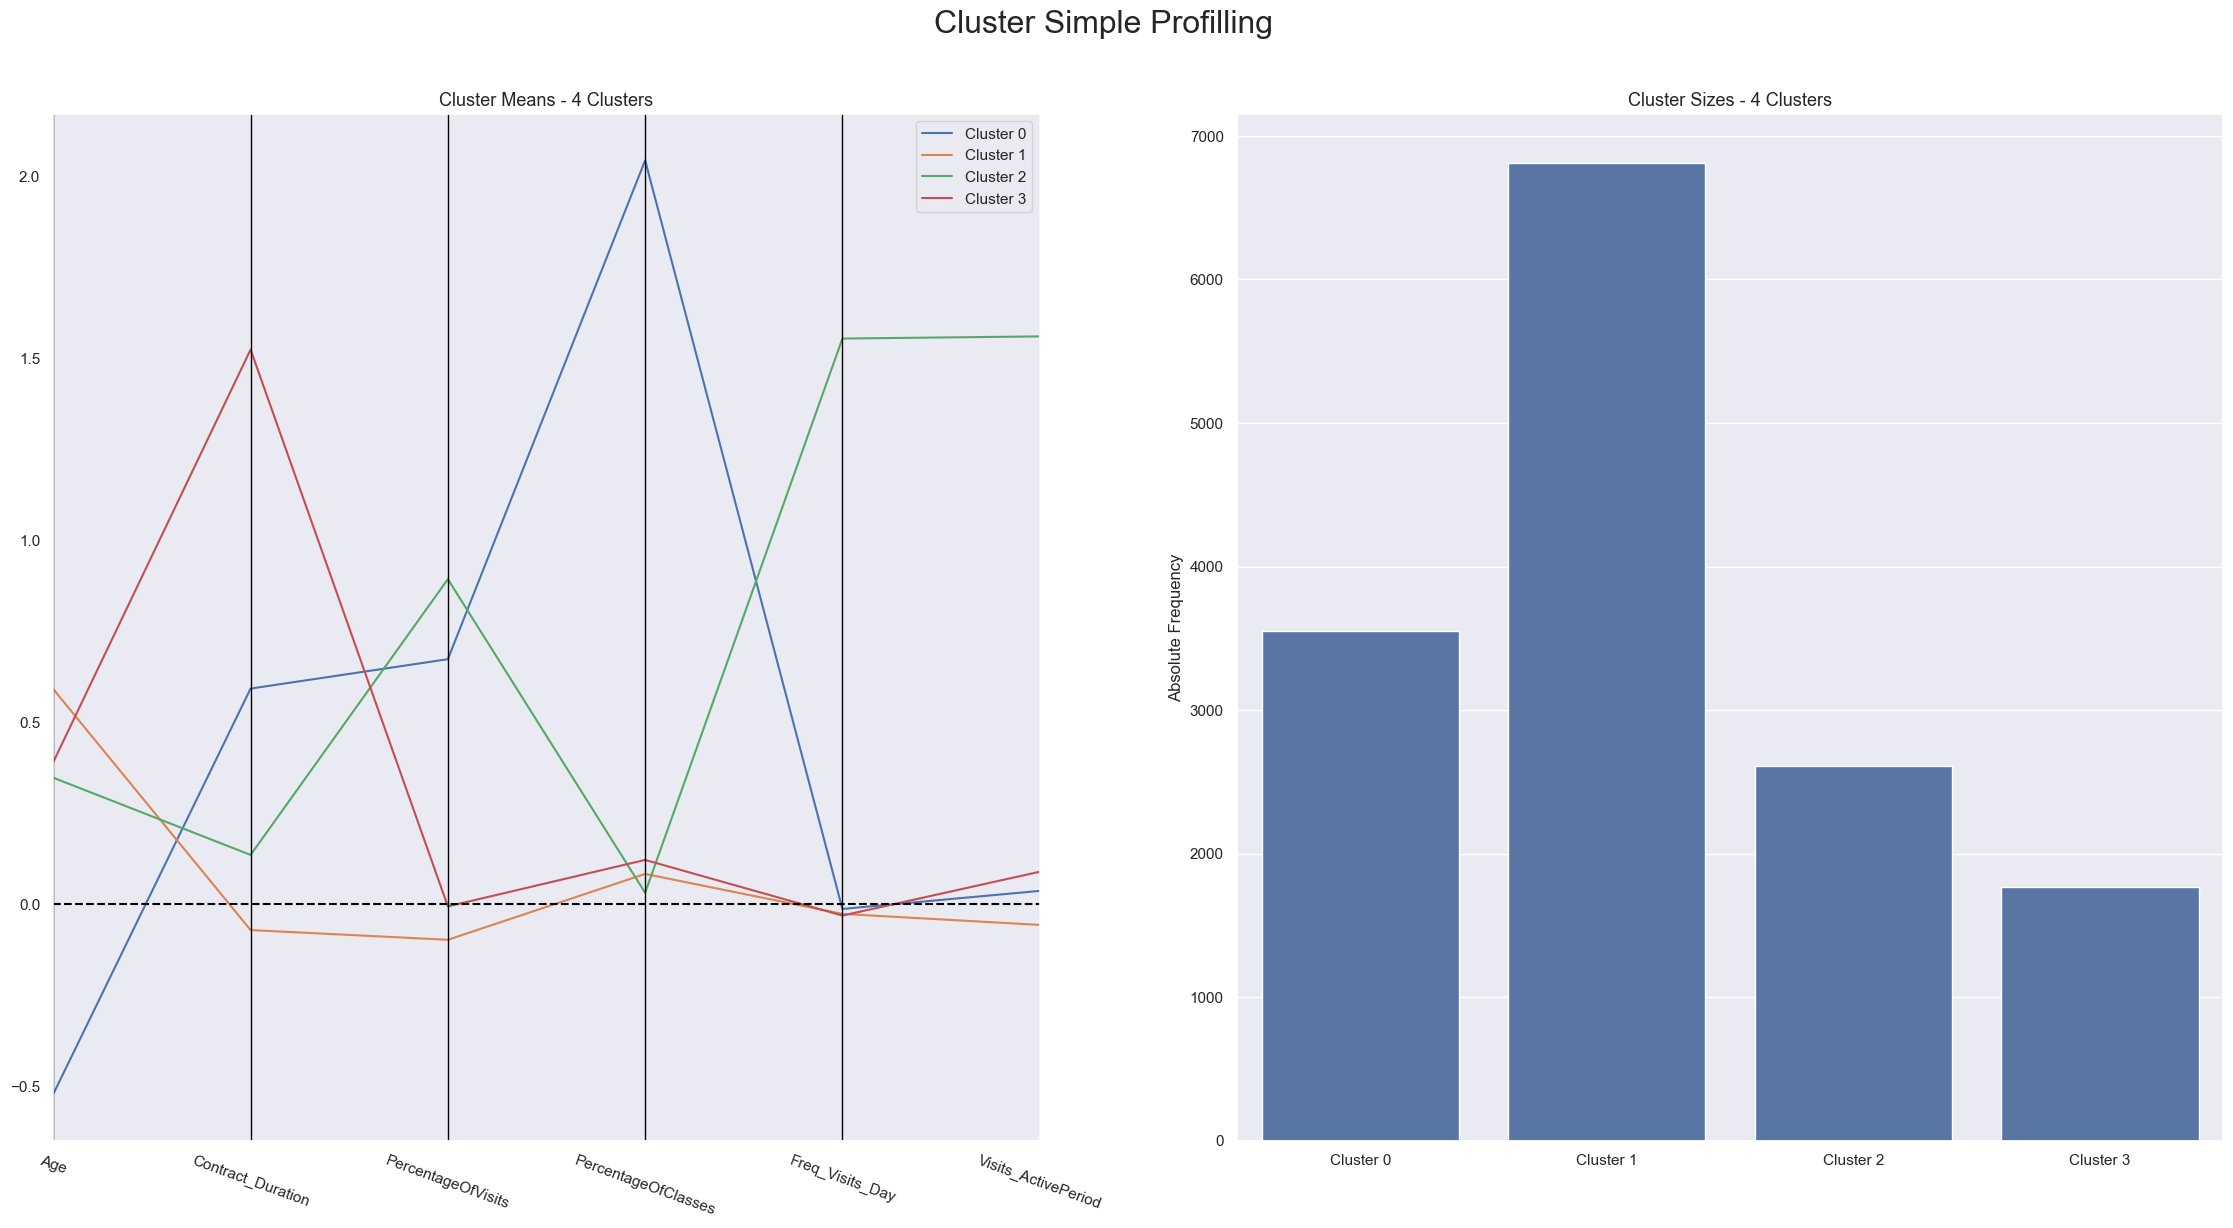

In [63]:
#create cluster profiling
cluster_profiles(
    df = df_final[metric_features + ["label"]], 
    label_columns = ["label"], 
    figsize = (28, 13), 
    compar_titles = [""]
)

## Gaussian Mixture Model:

**Gaussian Mixture Models** help represent normally distributed subpopulations within an overall population.\
It is a good model to use when clusters have different sizes, shapes, and orientations, so it is a possible approach to comprehend clusters we couldn't find before.

Assumes data is a mixture of Gaussians and is a good model for complex cluster shapes and overlapping clusters.

We need to define the **covariance_type** hyperparameter, that defines the degree of freedom in the shape of each cluster and the **n_components**:

We use **BIC** and **AIC** to define our best parameters, being the smallest value for these metric the best one (considering n_components = 4 as was used for the other models)

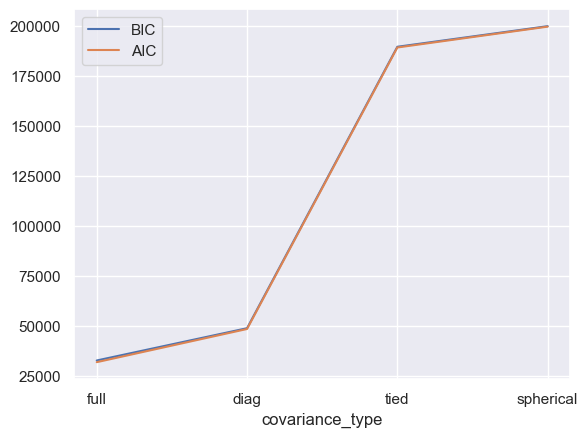

In [65]:
# Selecting covariance type based on AIC and BIC
cov_type = ['full','diag', 'tied', 'spherical']
models = [GaussianMixture(n_components=4, covariance_type=t, n_init=10, random_state=1).fit(df_general)
          for t in cov_type]

# TO-DO: compute the aic and bic values for each cluster solution. Use the appropriate GMM methods.
bic_values = [gmm.bic(df_general) for gmm in models]
aic_values = [gmm.aic(df_general) for gmm in models]
plt.plot(cov_type, bic_values, label='BIC')
plt.plot(cov_type, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('covariance_type')
plt.xticks(cov_type)
plt.show()

The smallest metrics ocur for "full".

We also verify is *n_componets* = 4 is a good number of clusters to consider fot this specific model:

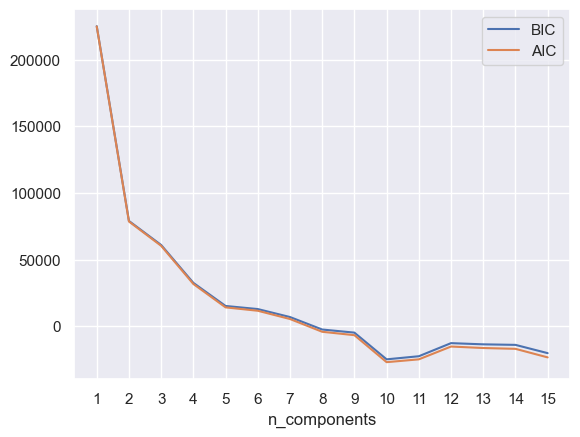

In [66]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 7)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_general)
          for n in n_components]

# TO-DO: compute the aic and bic values for each cluster solution. Use the appropriate GMM methods.
bic_values = [gmm.bic(df_general) for gmm in models]
aic_values = [gmm.aic(df_general) for gmm in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

Since we are comparing clustering algorithms with 4 clusters and the value *n_componets = 4* has both metrics close to 0, this value is kept.

The model was not achieving good results using defined values for *tol* (when the change resulting from an iteration is smaller tolerances, the iterations are terminated) and *reg_covar*, smaller values were selected: 

""The **covariance matrix** specifies the spread and orientation of the distribution. Along the diagonal of this covariance matrix we have the variance t  representing the shape (spread) along each of the dimensions. But then we also have the off-diagonal terms (these two thing actually take the same value because this a symmetric matrix) that specify the correlation structure of the distribution.""

""Regularization is applied to the diagnoals to prevent clusters from spreading too much (covariance matrix becoming too large).""

In [135]:
gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='k-means++', random_state=1, max_iter=3000, tol =1*10**-6,reg_covar = 1*10**-7)
gmm_labels = gmm.fit_predict(df_general)
labels_proba = gmm.predict_proba(df_general)
gmm_labels

array([3, 3, 1, ..., 1, 3, 3])

In [136]:
c= Counter(gmm_labels)
c

Counter({2: 5092, 1: 3679, 3: 3163, 0: 2604})

In [137]:
counter = []
for n in range(0,4):
    counter.append(round(c[n]/df_general.shape[0],4))
counter

[0.1791, 0.2531, 0.3503, 0.2176]

In [138]:
df_gmm = pd.concat([data, pd.Series(gmm_labels, index=data.index, name="gmm_labels")], axis=1)

In [139]:
sst = get_ss(df_gmm[general_perspective])  # get total sum of squares
ssw_labels = df_gmm[general_perspective + ["gmm_labels"]].groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.2300


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


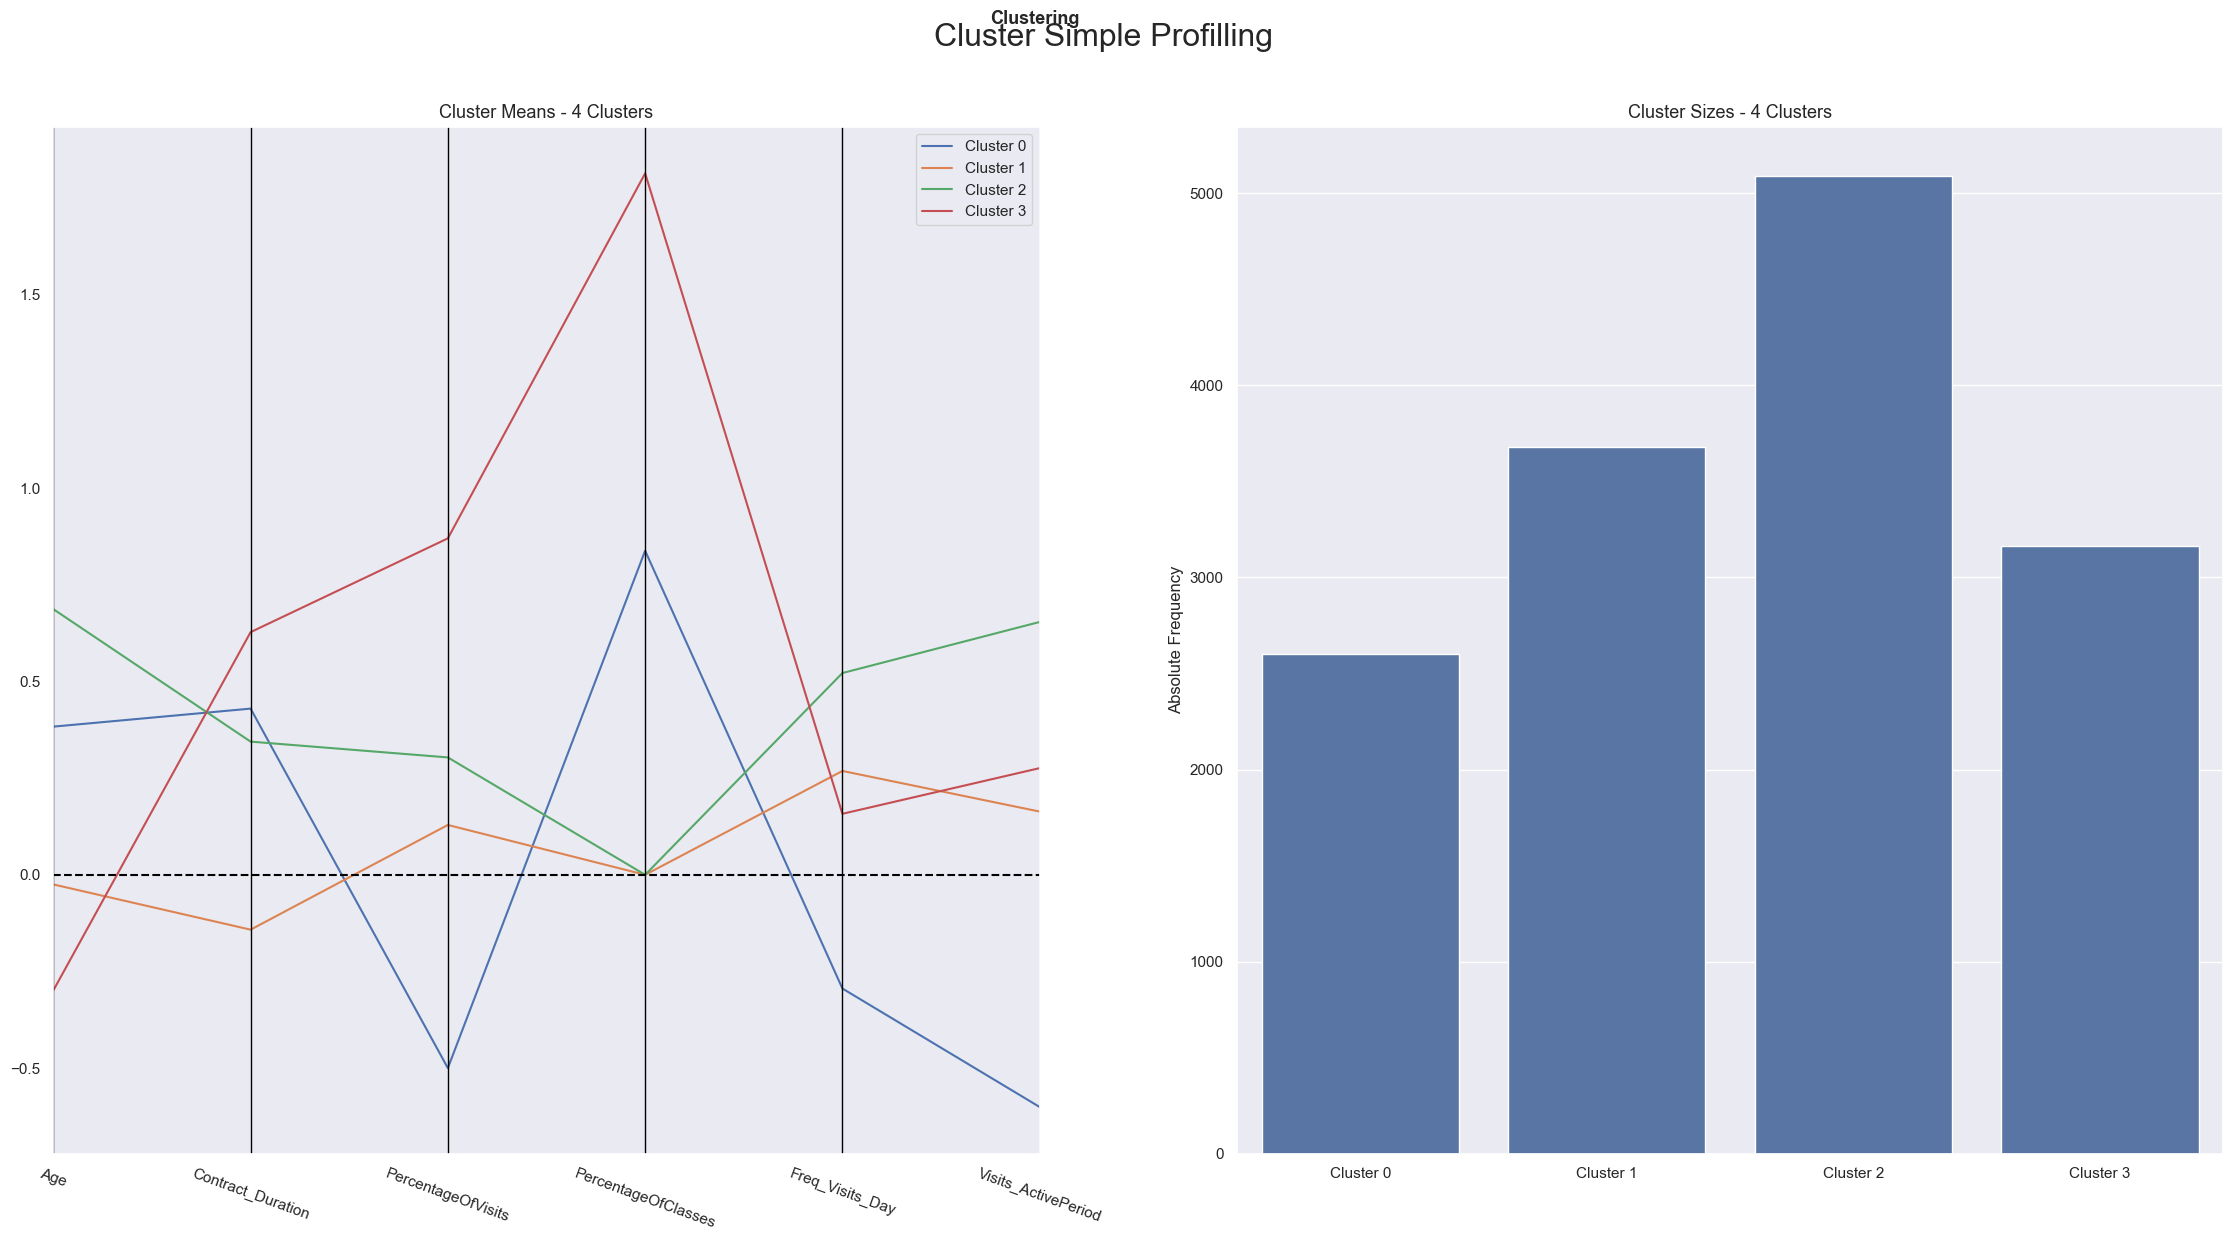

In [140]:
cluster_profiles(
    df = df_gmm[general_perspective + ["gmm_labels"]], 
    label_columns = ["gmm_labels"], 
    figsize = (28, 13), 
    compar_titles = ["Clustering"]
)

In [141]:
df_act= df_gmm[["gmm_labels"] + activities].groupby(["gmm_labels"]).sum()
df_compare= df_gmm[["gmm_labels"] + compare].groupby(["gmm_labels"]).sum()

We study the percentage of people who do an activity belong to this group. Since our activities are very unbalanced, this way we can see what percentage of all participants belong to a certain group:

In [142]:
df_act.apply(lambda col: col/(col.sum())).style.format(precision=2).background_gradient(axis=0)

,AthleticsActivities,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,CombatActivities,SpecialActivities,OtherActivities
gmm_labels,,,,,,,,
0,0.27,0.24,0.11,0.39,0.27,0.28,0.22,0.36
1,0.16,0.08,0.36,0.04,0.01,0.28,0.02,0.00
2,0.50,0.19,0.46,0.11,0.00,0.36,0.36,0.11
3,0.07,0.49,0.07,0.46,0.72,0.08,0.40,0.54


In [143]:
df_compare.apply(lambda col: col/(col.sum())).style.format(precision=2).background_gradient(axis=0)

,UseByTime,Dropout,Gender_Female
gmm_labels,,,
0,0.14,0.20,0.18
1,0.17,0.29,0.27
2,0.57,0.34,0.34
3,0.13,0.16,0.21
